# **Stanford Transportation - ChargePoint EV Chargers - Sep-2023**

## **Initialization**

### **Code Setup**

In [ ]:
import sys
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional

import matplotlib.dates
import networkx as nx
import pandas as pd
import seaborn as sns
import swifter
from IPython.display import display
from matplotlib import pyplot as plt
from zoneinfo import ZoneInfo

# sns.set_theme()

# Add repo's python directory to PYTHONPATH so we can import our utilities
sys.path.append("../python/")

from s3l_utils.dataset import Dataset
from s3l_utils.functional import grouper
from s3l_utils.notebook import print_md

%matplotlib widget

# Output formatting
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Timezone abbreviation to zoneinfo
tz_abbrev_to_zoneinfo = {
    "PDT": ZoneInfo("US/Pacific"),
    "PST": ZoneInfo("US/Pacific"),
}


# Convert alarm times to proper datetimes... why is this so hard???
def alarm_time_to_datetime(alarm_time):
    if isinstance(alarm_time, datetime):
        return alarm_time

    components = alarm_time.split()
    naive_time = datetime.strptime(" ".join(components[:-1]), "%Y-%m-%d %H:%M:%S")
    aware_time = naive_time.astimezone(tz_abbrev_to_zoneinfo[components[-1][1:-1]])
    return aware_time


# Summarize table
def summarize_dataframe_md(df: pd.DataFrame, header: str = ""):
    if header:
        print_md(f"#### **{header}**")

    print_md(f"**Number of Rows:** {len(df)}")
    print_md(f'**Columns:** {", ".join(df.columns)}')

    print_md("#### **Unique Column Values**")
    for column in df.columns:
        unique_column_values = ", ".join(filter(None, map(str, list(df[column].unique()))))
        print_md(f"##### **{column.strip()}**")
        print_md(unique_column_values)


# Pandas options
# pd.set_option('display.max_rows', None)


### **Load and Prepare Dataset**

In [ ]:
# Load dataset and tables
dataset = Dataset("../data/manifest.yml")
station_overview = dataset.stations.overview
alarms = dataset.reports.alarms
station_inventory = dataset.organizations.inventory.stations

# Canonicalize alarm times to US/Pacific datetimes
if not pd.api.types.is_datetime64_any_dtype(alarms["Alarm Time"]):
    # alarms['Alarm Time'] = pd.to_datetime(alarms['Alarm Time'].map(lambda x: ' '.join(x.split()[:-1]))).dt.tz_localize('US/Pacific', ambiguous='NaT')
    dst_map = alarms["Alarm Time"].str.contains("PST")
    alarms["Alarm Time"] = pd.to_datetime(alarms["Alarm Time"].map(lambda x: " ".join(x.split()[:-1]))).dt.tz_localize(
        "US/Pacific", dst_map
    )


## **Data Exploration**

### **Station Overview**

In [ ]:
summarize_dataframe_md(station_overview, "Station Overview Summary")


### **Station and Port Status**

In [ ]:
num_stations = len(station_overview)
num_ports = station_overview["No. of Ports"].sum()

print_md(f"**Number of Stations:** {num_stations}")
print_md(f"**Number of Ports:** {num_ports}")

print_md("#### **Station Count by Status**")
station_status_counts = station_overview.value_counts("Station Status")
assert num_stations == station_status_counts.sum()
display(station_status_counts.to_frame())

num_stations_need_service_or_watch_list = station_status_counts.loc[["Watch List", "Needs Service"]].sum()
percent_stations_need_service_or_watch_list = round(num_stations_need_service_or_watch_list / num_stations * 100, 2)
print_md(
    f"**Stations Needing Service or on Watch List:** {num_stations_need_service_or_watch_list} ({percent_stations_need_service_or_watch_list}%)"
)

print_md("#### **Port Count by Status**")
port_status_counts = station_overview[["Port 1 Status", "Port 2 Status"]].melt()["value"].value_counts().drop("")
assert num_ports == port_status_counts.sum()
display(port_status_counts.to_frame())

num_ports_need_service_or_watch_list = port_status_counts.loc[["Watch List", "Needs Service"]].sum()
percent_ports_need_service_or_watch_list = round(num_ports_need_service_or_watch_list / num_ports * 100, 2)
print_md(
    f"**Ports Needing Service or on Watch List:** {num_ports_need_service_or_watch_list} ({percent_ports_need_service_or_watch_list}%)"
)


### **Alarms**

In [ ]:
summarize_dataframe_md(alarms.drop("Alarm Time", axis=1), "Alarms Summary")


In [ ]:
alarm_name_vcs = alarms["Alarm Name"].value_counts()
display(alarm_name_vcs.sort_index())
for x in alarm_name_vcs.sort_index().index:
    print(x)
# alarm_name.hist(xrot=90, bins=alarm_name.nunique(), density=True)
ax = (alarm_name_vcs / alarm_name_vcs.sum()).plot.bar(color="black")
ax.grid()


## **Charger State Model**

### **Charger State Model**

In [ ]:
def calculate_state_from_alarms(alarms):
    from chargepoint import AlarmEnum, ChargerModel

    # Mapping from MAC addresses to models. Each MAC address corresponds to one unique charger model.
    models: dict[str, ChargerModel] = {}

    state_alarms = alarms.copy()
    state_alarms["State"] = pd.Series()

    # Iterate through all alarms chronologically and send to underlying charger state models.
    for index, row in state_alarms.sort_values("Alarm Time").iterrows():
        mac = row["MAC Address"]
        if mac in models:
            model = models[mac]
        else:
            model = ChargerModel(return_to_last_known_state=True)
            models[mac] = model

        alarm = AlarmEnum(row["Alarm Name"])
        model.send(alarm)
        state_alarms.loc[index, "State"] = model.state.station_status.current_state.name

    return state_alarms


state_alarms = calculate_state_from_alarms(alarms)


In [ ]:
state_alarms


### **State History**

In [ ]:
def build_state_history(state_alarms):
    # Sort state alarms by MAC Address and Alarm Time
    state_alarms = state_alarms.sort_values(["MAC Address", "Alarm Time"])

    # For duplicate alarm times (for a given charger), only keep latest alarm
    state_alarms = state_alarms.drop_duplicates(["MAC Address", "Alarm Time"], keep="last")

    state_history = None

    # Compute state history for each charger
    # Derived from:
    # https://www.codeforests.com/2021/03/30/group-consecutive-rows-in-pandas/
    # https://stackoverflow.com/questions/26911851/how-to-use-pandas-to-find-consecutive-same-data-in-time-series
    for mac, group in state_alarms.groupby("MAC Address"):
        group["Period"] = (group.State != group.State.shift()).cumsum()
        period_group = group.groupby("Period")
        charger_state_history = pd.DataFrame(
            {
                "State": period_group.State.first(),
                "Time": period_group["Alarm Time"].first(),
                "Alarms": period_group.size(),
            }
        ).reset_index(drop=True)

        charger_state_history["MAC Address"] = mac
        charger_state_history["Period"] = charger_state_history.index

        # Calculate duration
        charger_state_history["Duration"] = charger_state_history["Time"].shift(-1) - charger_state_history["Time"]

        # Order columns
        charger_state_history = charger_state_history[["MAC Address", "Period", "State", "Time", "Duration", "Alarms"]]

        # Concat
        if state_history is None:
            state_history = charger_state_history
        else:
            state_history = pd.concat([state_history, charger_state_history])

    return state_history


state_history = build_state_history(state_alarms).dropna()


In [ ]:
state_history


In [ ]:
state_history["Duration"].to_frame().describe()

## **Analysis**

### **Uptime Summary**

In [ ]:
state_durations = state_history.pivot_table(
    index="MAC Address", columns="State", values="Duration", aggfunc="sum", fill_value=pd.Timedelta(seconds=0)
)
state_durations["Total"] = state_durations.sum(axis=1)

with pd.option_context("display.max_rows", None):
    display(state_durations)


In [ ]:
state_percentages = state_durations.divide(state_durations["Total"], axis=0) * 100

with pd.option_context("display.max_rows", None):
    display(state_percentages)


In [ ]:
state_percentages.describe()

### **State History**

#### **Per-Charger Timeline**

In [ ]:
state_to_plot_map = {
    "Available": {
        # 'color': '#54CD48',
        "color": "#0080B2",
        "label": "Available",
    },
    "Faulted": {"color": "#D31144", "label": "Faulted"},
    "Unreachable": {"color": "#EEAC11", "label": "Unreachable"},
    "Unavailable": {"color": "#454545", "label": "Unavailable"},
    "Unknown": {"color": "black", "label": "Unknown"},
}

# %matplotlib qt
%matplotlib widget
fig, ax = plt.subplots()

for i, mac in enumerate(state_history["MAC Address"].unique()):
    # min_time = float('inf')
    y = i * 20
    for state, properties in state_to_plot_map.items():
        state_periods = state_history[(state_history["MAC Address"] == mac) & (state_history.State == state)]
        xranges = [(row.Time.timestamp(), row.Duration.total_seconds()) for _, row in state_periods.iterrows()]
        # if xranges:
        #     min_time = min(min([x[0] for x in xranges]), min_time)
        ax.broken_barh(xranges, (y, 10), **properties)
    # ax.text(min_time - 1, y, mac, ha='right', fontsize=8)
    # ax.annotate(mac, xy=(min_time, y), ha='right')

# locs = ax.get_xticks()
# labels = list(map(lambda x: pd.Timestamp(x, unit='s', tz='US/Pacific'), locs))
ax.xaxis.set_major_formatter(lambda x, pos: pd.Timestamp(x, unit="s", tz="US/Pacific"))
plt.xticks(rotation=90)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    fancybox=True,
    ncols=5,
    shadow=True,
)
plt.yticks([])
plt.ylabel("Charger")
plt.tight_layout()


#### **Resample State History**

In [ ]:
state_history["State"] = state_history["State"].astype("category")

resampled_state_history = state_history.pivot(columns="MAC Address", index="Time", values="State")

# ffill except last range of NaNs
resampled_state_history = resampled_state_history.apply(lambda series: series.loc[: series.last_valid_index()].ffill())

# Resample
resampled_state_history = resampled_state_history.resample("1T").ffill()

# ffill except last range of NaNs
# resampled_state_history = resampled_state_history.apply(lambda series: series.loc[:series.last_valid_index()].ffill())


In [ ]:
resampled_state_counts_csv_path = Path("./big_chungus.csv")
if resampled_state_counts_csv_path.exists():
    resampled_state_counts = pd.read_csv(resampled_state_counts_csv_path, index_col="Time")
    resampled_state_counts.index = pd.to_datetime(resampled_state_counts.index, utc=True).tz_convert("US/Pacific")
else:
    resampled_state_counts = resampled_state_history.swifter.apply(pd.Series.value_counts, axis=1)
    resampled_state_counts["Total"] = resampled_state_counts.sum(axis=1)
    resampled_state_counts = resampled_state_counts[resampled_state_counts["Total"] > 0]


In [ ]:
resampled_state_counts_normalized = resampled_state_counts.divide(resampled_state_counts["Total"], axis=0) * 100

In [ ]:
resampled_state_counts_normalized

#### **Summary Graphs**

In [ ]:
sns.set_theme()
ax = resampled_state_counts_normalized.groupby(resampled_state_counts_normalized.index.year).mean().plot.bar(y='Available', title='Uptime vs. Year', xlabel='Year', ylabel='Uptime')

#### **Summarized Timeline**

In [ ]:
ax = resampled_state_counts.plot.area(
    y=["Unknown", "Unavailable", "Faulted", "Unreachable", "Available"],
    rot=0,
    ylabel="# Chargers",
    xlabel="Date",
    title="Charger Statuses Over Time",
    style={
        "Unknown": "purple",
        "Unavailable": "#454545",
        "Unreachable": "#EEAC11",
        "Faulted": "#D31144",
        "Available": "#0080B2",
    },
)

fig = ax.get_figure()
fig.set_figwidth(fig.get_figwidth() * 2)
ax.get_figure().tight_layout()

### **State Transition Frequency**

In [ ]:
state_transitions_freq = (
    state_history[["MAC Address", "Period", "Duration"]]
    .groupby("MAC Address")
    .agg(Periods=pd.NamedAgg(column="Period", aggfunc="count"), Duration=pd.NamedAgg(column="Duration", aggfunc="sum"))
)
# state_transitions_freq['Duration / Period'] = state_transitions_freq['Duration'] / state_transitions_freq['Periods']
state_transitions_freq["Frequency"] = (state_transitions_freq["Periods"] - 0) / state_transitions_freq["Duration"].dt.seconds

with pd.option_context("display.max_rows", None):
    display(state_transitions_freq.sort_values("Frequency", ascending=False))


#### **vs. Uptime**

In [ ]:
pd.concat([state_percentages, state_transitions_freq['Frequency']], axis=1).sort_values('Frequency', ascending=False).plot.scatter(x='Frequency', y='Available')


### **By Location**

##### **Station to Location Tables**

In [ ]:
# Inventory - MAC, Name, Address
inventory_mac_name_address = station_inventory[["MAC Address", "Station Name", "Address"]]
inventory_mac_name_address = inventory_mac_name_address.rename(columns={"Station Name": "Name"})
inventory_mac_name_address = inventory_mac_name_address.sort_values("MAC Address", ignore_index=True)

# Alarms - MAC, Name, Address
alarms_mac_name_address = alarms[["MAC Address", "Display Name"]].drop_duplicates()

# Map some addresses using alarm MAC addresses
alarms_mac_name_address["Address"] = alarms_mac_name_address.merge(
    station_inventory[["MAC Address", "Address"]], left_on="MAC Address", right_on="MAC Address"
)["Address"]

# Map some addresses using display / station names
alarms_missing_addresses = alarms_mac_name_address[alarms_mac_name_address["Address"].isna()]
alarms_mac_name_address.update(
    alarms_missing_addresses.drop("Address", axis=1)
    .merge(station_inventory[["Station Name", "Address"]], how="left", left_on="Display Name", right_on="Station Name")
    .set_index(alarms_missing_addresses.index)
)

alarms_mac_name_address = alarms_mac_name_address.rename(columns={"Display Name": "Name"}).sort_values(
    "MAC Address", ignore_index=True
)

# Combined Alarms and Inventory table
station_mac_name_address = (
    pd.concat([inventory_mac_name_address, alarms_mac_name_address], ignore_index=True)
    .drop_duplicates()
    .sort_values("MAC Address", ignore_index=True)
)

# Map some addresses using duplicate MACs
## First get all duplicates
duplicate_stations_mac = station_mac_name_address[
    station_mac_name_address.duplicated(subset="MAC Address", keep=False)
]

## Drop duplicates from frame. We will add back the resolved duplicates later.
station_mac_name_address.drop(duplicate_stations_mac.index, inplace=True)

def duplicate_resolver(duplicates):
    resolved_rows = []
    unresolved_rows = []
    for mac, group in duplicates.groupby("MAC Address"):
        group.dropna(inplace=True)

        if len(group) == 1:
            resolved_rows.append(group)
        elif mac in station_inventory['MAC Address'].values:
            resolved_rows.append(station_inventory[station_inventory['MAC Address'] == mac][['MAC Address', 'Station Name', 'Address']].rename(columns={'Station Name': 'Name'}))
        else:
            print(f'Could not resolve duplicates for {mac}')
            unresolved_rows.append(group)

    resolved_duplicates = pd.concat(resolved_rows) if resolved_rows else pd.DataFrame()
    unresolved_duplicates = pd.concat(unresolved_rows) if unresolved_rows else pd.DataFrame()
    return resolved_duplicates, unresolved_duplicates


## Resolve duplicates and add back to combined frame
resolved_duplicates, unresolved_duplicates = duplicate_resolver(duplicate_stations_mac)
station_mac_name_address = pd.concat([station_mac_name_address, resolved_duplicates]).sort_values("Name", ignore_index=True)

# Manual location map
station_mac_name_address.loc[station_mac_name_address['MAC Address'] == '0024:B100:0002:8F36', 'Address'] = '425 Broadway, Redwood City, California 94063, United States'
station_mac_name_address.loc[station_mac_name_address['MAC Address'] == '0024:B100:0002:91B6', 'Address'] = '2850 Bay Rd, Redwood City, California 94063, United States'

# Remaining
alarms_missing_address = station_mac_name_address[station_mac_name_address["Address"].isna()]

print_md("**Inventory: MAC, Name, Address**")
display(inventory_mac_name_address)

print_md("**Alarms: MAC, Name, Address**")
display(alarms_mac_name_address)

print_md("**Duplicate Stations (by MAC)**")
display(duplicate_stations_mac)

# print_md("**Resolved Duplicates**")
# display(resolved_duplicates)

print_md("**Unresolved Duplicates**")
display(unresolved_duplicates)

print_md("**Resolved Stations: MAC, Name, Address**")
display(station_mac_name_address.sort_values('Address', ignore_index=True))

with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    print_md("**Remaining MACs with no Address**")
    display(alarms_missing_address)

# Normalize names
address_location_map = {
    '2850 Bay Rd, Redwood City, California 94063, United States': 'RWC',
    '2858 Bay Rd, Redwood City, California 94063, United States': 'RWC',
    '287 Santa Teresa St, Stanford, California 94305, United States': 'Roble Field Garage',
    '295 Galvez St, Stanford, California 94305, United States': 'Angell Field Lot',
    '340 Oak Rd, Stanford, California 94305, United States': 'Stock Farm Garage',
    '360 Oak Rd, Stanford, California 94305, United States': 'Stock Farm Garage',
    '373 Santa Teresa St, Stanford, California 94305, United States': 'Roble Field Garage',
    '375 Santa Teresa St, Stanford, California 94305, United States': 'Roble Field Garage',
    '400 El Camino Real, Menlo Park, California 94025, United States': 'Menlo Park',
    '425 Broadway, Redwood City, California 94063, United States': 'RWC',
    '453 Quarry Rd, Palo Alto, California 94304, United States': 'CAM Garage',
    '484 Oak Rd, Stanford, California 94305, United States': 'ESF Lot',
    '495 El Camino Real, Menlo Park, California 94025, United States': 'Menlo Park',
    '526-566 Lagunita Dr, Stanford, California 94305, United States': 'Tresidder Lot',
    '526-566 Stanford UniversityLagunita Dr, Stanford, California 94305, United States': 'Tresidder Lot',
    '585 Broadway, Redwood City, California 94063, United States': 'RWC',
    '671-725 Panama St, Stanford, California 94305, United States': 'Roble Field Garage',
    '740 Serra St, Stanford, California 94305, United States': 'Thoburn Garage',
    '742 Campus Drive, Manzanita Garage, Stanford, California 94305, United States': 'Manzanita Field Garage',
    '742 Campus Drive, Stanford, California 94305, United States': 'Manzanita Field Garage',
    '900-998 Douglas Ave, Redwood City, California 94063, United States': 'RWC'
}

print_md("**Address to Location Map**")
display(address_location_map)

station_location = station_mac_name_address.copy()
station_location['Location'] = station_location['Address'].map(address_location_map)

with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    print_md("**Stations**")
    display(station_location)

#### **Summary by Location**


In [300]:
state_breakdown_location = state_percentages.copy()
state_breakdown_location['Location'] = state_breakdown_location.index.to_series().map(station_location.set_index('MAC Address')['Location'])

location_summary = state_breakdown_location.groupby('Location').describe()
display(location_summary)

State                  Available                                              \
                           count       mean        std        min        25%   
Location                                                                       
Angell Field Lot             3.0  97.063183   2.509366  94.191304  96.178513   
CAM Garage                   5.0  74.397692   9.916421  59.385289  70.318910   
ESF Lot                      1.0  97.990056        NaN  97.990056  97.990056   
Manzanita Field Garage      12.0  64.606703  35.321186   6.557406  48.114293   
Menlo Park                  10.0  98.573263   1.470942  95.000435  98.748372   
RWC                         34.0  85.323425  15.427350  36.601522  73.863260   
Roble Field Garage          33.0  92.066301   6.354896  69.906417  87.700536   
Stock Farm Garage            9.0  88.010747   3.780420  82.874010  86.002838   
Thoburn Garage              12.0  73.696592   3.850893  70.453016  71.074253   
Tresidder Lot                4.0  89.426909  11.728038  72.248481  86.756689   

State                                                   Faulted             \
                              50%        75%        max   count       mean   
Location                                                                     
Angell Field Lot        98.165721  98.499122  98.832523     3.0   2.048008   
CAM Garage              77.553849  79.681080  85.049332     5.0   6.501748   
ESF Lot                 97.990056  97.990056  97.990056     1.0   0.045185   
Manzanita Field Garage  74.716605  92.420366  98.552017    12.0  24.819579   
Menlo Park              99.238365  99.387684  99.594236    10.0   0.715501   
RWC                     88.375122  98.700416  99.755561    34.0   8.651780   
Roble Field Garage      94.968323  97.592308  99.838665    33.0   4.005321   
Stock Farm Garage       87.829740  88.208666  94.454121     9.0   4.070442   
Thoburn Garage          71.960421  76.161064  83.326734    12.0  13.574709   
Tresidder Lot           94.120419  96.790639  97.218316     4.0   6.151587   

State                                                                        \
                              std       min       25%        50%        75%   
Location                                                                      
Angell Field Lot         2.837484  0.393187  0.409814   0.426441   2.875418   
CAM Garage               7.633070  2.373760  2.688451   3.655617   3.673871   
ESF Lot                       NaN  0.045185  0.045185   0.045185   0.045185   
Manzanita Field Garage  32.885404  0.085950  0.333758  10.651072  33.598498   
Menlo Park               1.549134  0.000000  0.000000   0.000000   0.001787   
RWC                     10.748335  0.000000  0.255981   3.036344  17.952085   
Roble Field Garage       5.119403  0.000000  0.556923   2.188537   5.421186   
Stock Farm Garage        2.001138  0.554962  3.662366   4.293710   4.790407   
Thoburn Garage           8.407666  1.069496  5.297283  15.338098  21.362397   
Tresidder Lot            9.033420  0.456618  1.787316   2.253885   6.618156   

State                             Unavailable                                \
                              max       count      mean       std       min   
Location                                                                      
Angell Field Lot         5.324396         3.0  0.367256  0.355983  0.000000   
CAM Garage              20.117040         5.0  0.003231  0.004785  0.000000   
ESF Lot                  0.045185         1.0  0.001442       NaN  0.001442   
Manzanita Field Garage  82.922008        12.0  2.290374  4.370158  0.000000   
Menlo Park               4.330534        10.0  0.012818  0.008010  0.002737   
RWC                     40.142470        34.0  1.548355  4.878964  0.000000   
Roble Field Garage      23.868776        33.0  0.653795  1.190705  0.000000   
Stock Farm Garage        7.792305         9.0  0.194493  0.574247  0.000000   
Thoburn Garage          22.180037        12.0  

#### **Resampled State History w/ Location**

In [ ]:
# resampled_state_counts_location = resampled_state_counts.copy()
# resampled_state_counts_location['Location'] = resampled_state_counts_location.index.to_series().map(station_location.set_index('MAC Address')['Location'])

#### **Per-Location Summarized Timelines**

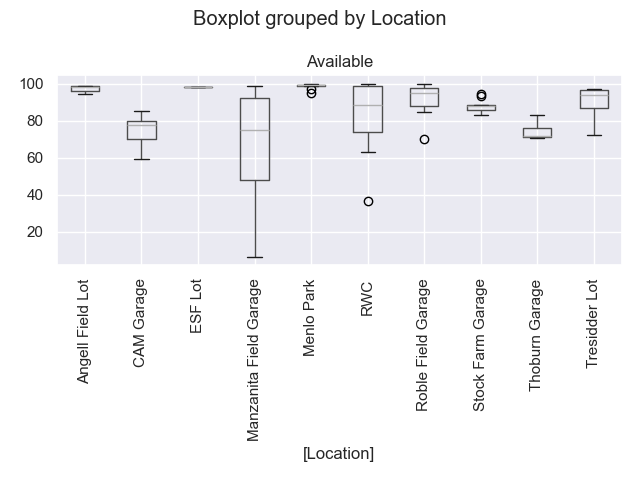

In [301]:
ax = state_breakdown_location[['Available', 'Location']].boxplot(by='Location', rot=90)
ax.figure.tight_layout()